In [1]:
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf
import numpy as np
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
import keras 

optimizers = keras.optimizers

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import preprocessing
from sklearn.externals import joblib
# from seq_feature_generate import seq_feature_generate
# from seq_feature_generate_v2 import seq_feature_generate_v2
from util_func.eval_function import auroc, cal_ks, auc, ks, fea_psi_calc
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing.data import OneHotEncoder
from sklearn import metrics
import sys
import math
from sklearn.metrics import roc_auc_score
import gc
from util_func import TCN_V3 as TCN
from util_func import self_attention as sf
from util_func.look_ahead import Lookahead
from util_func.LayerNormalization import LayerNormalization
import seaborn as sns
import random
from scipy import optimize
from sklearn.metrics import r2_score

load_model =  keras.models.load_model
Sequential = keras.models.Sequential
Dense = keras.layers.Dense
Activation = keras.layers.Activation
Dropout = keras.layers.Dropout
initializers = keras.initializers
regularizers = keras.regularizers
optimizers = keras.optimizers
Input = keras.layers.Input
add = keras.layers.add
Model = keras.models.Model
BatchNormalization = keras.layers.BatchNormalization 
EarlyStopping =  keras.callbacks.EarlyStopping
ModelCheckpoint = keras.callbacks.ModelCheckpoint
K = keras.backend
Concatenate = keras.layers.Concatenate
Reshape = keras.layers.Reshape
Flatten = keras.layers.Flatten
Lambda = keras.layers.Lambda

In [3]:
class MyFlatten(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(MyFlatten, self).__init__(**kwargs)

    def compute_mask(self, inputs, mask=None):
        if mask==None:
            return mask
        return K.batch_flatten(mask)

    def call(self, inputs, mask=None):
        return K.batch_flatten(inputs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], np.prod(input_shape[1:]))
    



class MyMeanPool(Layer):
    def __init__(self, axis, **kwargs):
        self.supports_masking = True
        self.axis = axis
        super(MyMeanPool, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        # need not to pass the mask to next layers
        return None

    def call(self, x, mask=None):
        if mask is not None:
            if K.ndim(x)!=K.ndim(mask):
                mask = K.repeat(mask, x.shape[-1])
                mask = tf.transpose(mask, [0,2,1])
            mask = K.cast(mask, K.floatx())
            x = x * mask
            return K.sum(x, axis=self.axis) / K.sum(mask, axis=self.axis)
        else:
            return K.mean(x, axis=self.axis)

    def compute_output_shape(self, input_shape):
        output_shape = []
        for i in range(len(input_shape)):
            if i!=self.axis:
                output_shape.append(input_shape[i])
        return tuple(output_shape)
    

class MySumLayer(Layer):
    def __init__(self, axis, **kwargs):
        self.supports_masking = True
        self.axis = axis
        super(MySumLayer, self).__init__(**kwargs)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        
        if mask is not None:
            # mask (batch, time)
            mask = K.cast(mask, K.floatx())
            if K.ndim(x)!=K.ndim(mask):
                mask = K.repeat(mask, x.shape[-1])
                mask = tf.transpose(mask, [0,2,1])
            x = x * mask
            if K.ndim(x)==2:
                x = K.expand_dims(x)
            return K.sum(x, axis=self.axis)
        else:
            if K.ndim(x)==2:
                x = K.expand_dims(x)
            return K.sum(x, axis=self.axis)

    def compute_output_shape(self, input_shape):
        output_shape = []
        for i in range(len(input_shape)):
            if i!=self.axis:
                output_shape.append(input_shape[i])
        if len(output_shape)==1:
            output_shape.append(1)
        return tuple(output_shape)

# load data

In [4]:
data_dir = '/home/odin/chengbixiao/git_code/User_loan_demand/user_loan_demand/offline/data/0909/'
train_info_path = data_dir + 'feature_model_file/train_info.csv'
test1_info_path = data_dir + 'feature_model_file/test1_info.csv'
test_info_path = data_dir + 'feature_model_file/test_info.csv'

fm_feature_train_norm_path = data_dir + 'feature_model_file/fm_feature_train.npy'
fm_feature_test1_norm_path = data_dir + 'feature_model_file/fm_feature_test1.npy'
fm_feature_test_norm_path = data_dir + 'feature_model_file/fm_feature_test.npy'

train_label_path = data_dir + 'feature_model_file/train_label.npy'
test1_label_path = data_dir + 'feature_model_file/test1_label.npy'
test_label_path = data_dir + 'feature_model_file/test_label.npy'

train_loan_seq_matrix_path = data_dir + 'feature_model_file/train_loan_seq_matrix.npy'
train_repay_seq_matrix_path = data_dir + 'feature_model_file/train_repay_seq_matrix.npy'
train_event1_seq_matrix_path = data_dir + 'feature_model_file/train_event1_seq_matrix.npy'
train_event2_seq_matrix_path = data_dir + 'feature_model_file/train_event2_seq_matrix.npy'

test1_loan_seq_matrix_path = data_dir + 'feature_model_file/test1_loan_seq_matrix.npy'
test1_repay_seq_matrix_path = data_dir + 'feature_model_file/test1_repay_seq_matrix.npy'
test1_event1_seq_matrix_path = data_dir + 'feature_model_file/test1_event1_seq_matrix.npy'
test1_event2_seq_matrix_path = data_dir + 'feature_model_file/test1_event2_seq_matrix.npy'

test_loan_seq_matrix_path = data_dir + 'feature_model_file/test_loan_seq_matrix.npy'
test_repay_seq_matrix_path = data_dir + 'feature_model_file/test_repay_seq_matrix.npy'
test_event1_seq_matrix_path = data_dir + 'feature_model_file/test_event1_seq_matrix.npy'
test_event2_seq_matrix_path = data_dir + 'feature_model_file/test_event2_seq_matrix.npy'

stat_feature_train_norm_path = data_dir + 'feature_model_file/stat_feature_train.npy'
stat_feature_test1_norm_path = data_dir + 'feature_model_file/stat_feature_test1.npy'
stat_feature_test_norm_path = data_dir + 'feature_model_file/stat_feature_test.npy'



In [5]:

fm_user_fins_feature_train_norm_path = data_dir + 'feature_model_file/fm_user_fins_feature_train.npy'
fm_user_fins_feature_test1_norm_path = data_dir + 'feature_model_file/fm_user_fins_feature_test1.npy'
fm_user_fins_feature_test_norm_path = data_dir + 'feature_model_file/fm_user_fins_feature_test.npy'
fm_user_people_feature_train_norm_path = data_dir + 'feature_model_file/fm_user_people_feature_train.npy'
fm_user_people_feature_test1_norm_path = data_dir + 'feature_model_file/fm_user_people_feature_test1.npy'
fm_user_people_feature_test_norm_path = data_dir + 'feature_model_file/fm_user_people_feature_test.npy'
fm_account_feature_train_norm_path = data_dir + 'feature_model_file/fm_account_feature_train.npy'
fm_account_feature_test1_norm_path = data_dir + 'feature_model_file/fm_account_feature_test1.npy'
fm_account_feature_test_norm_path = data_dir + 'feature_model_file/fm_account_feature_test.npy'

new_model_pred_train_path = data_dir + 'model_file/fm_pred_train.csv'
new_model_pred_test_path = data_dir + 'model_file/fm_pred_test.csv'
new_model_pred_test1_path = data_dir + 'model_file/fm_pred_test1.csv'
save_model_file = data_dir + 'model_file/fm_64_107_3_0909.h5'

In [6]:
save_pb_file_path = data_dir + 'model_file'
save_pb_file_name = 'demand_card_model_v1_online.pb'

In [6]:
fm_feature_train_norm = np.load(fm_feature_train_norm_path)
fm_feature_test1_norm = np.load(fm_feature_test1_norm_path)
fm_feature_test_norm = np.load(fm_feature_test_norm_path)

train_event_seq_matrix = np.load(train_event2_seq_matrix_path)
train_loan_seq_matrix = np.load(train_loan_seq_matrix_path)
train_repay_seq_matrix = np.load(train_repay_seq_matrix_path)

test_event_seq_matrix = np.load(test_event2_seq_matrix_path)
test_loan_seq_matrix = np.load(test_loan_seq_matrix_path)
test_repay_seq_matrix = np.load(test_repay_seq_matrix_path)

test1_event_seq_matrix = np.load(test1_event2_seq_matrix_path)
test1_loan_seq_matrix = np.load(test1_loan_seq_matrix_path)
test1_repay_seq_matrix = np.load(test1_repay_seq_matrix_path)

baseline_feature_top_train_norm = np.load(stat_feature_train_norm_path)
baseline_feature_top_test_norm = np.load(stat_feature_test_norm_path)
baseline_feature_top_test1_norm = np.load(stat_feature_test1_norm_path)

train_label = np.load(train_label_path)
test_label = np.load(test_label_path)
test1_label = np.load(test1_label_path)

In [7]:
len(train_label)

812883

In [8]:
len([x for x in test_label if x == 1])/len([x for x in test_label if x == 0])

0.39216165683877463

In [9]:
fm_user_fins_feature_train_norm = np.load(fm_user_fins_feature_train_norm_path)
fm_user_fins_feature_test1_norm = np.load(fm_user_fins_feature_test1_norm_path)
fm_user_fins_feature_test_norm = np.load(fm_user_fins_feature_test_norm_path)
fm_user_people_feature_train_norm = np.load(fm_user_people_feature_train_norm_path)
fm_user_people_feature_test1_norm = np.load(fm_user_people_feature_test1_norm_path)
fm_user_people_feature_test_norm = np.load(fm_user_people_feature_test_norm_path)
fm_account_feature_train_norm = np.load(fm_account_feature_train_norm_path)
fm_account_feature_test1_norm = np.load(fm_account_feature_test1_norm_path)
fm_account_feature_test_norm = np.load(fm_account_feature_test_norm_path)

In [11]:
LOAN_SEQ_LENGTH=10
LOAN_FEATURE_NUM=26

REPAY_SEQ_LENGTH=15
REPAY_FEATURE_NUM=17
# EVENT_ACTION_SEQ_LENGTH=30
# EVENT_ACTION_FEATURE_NUM=2

EVENT_SEQ_LENGTH=20
EVENT_FEATURE_NUM=55

STAT_FEATURE_NUM = 194
FM_FEA_DIM=107

FM_ACCOUNT_FEA_DIM=39
FM_USER_FINS_FEA_DIM=22
FM_USER_PEOPLE_FEA_DIM=46

K.clear_session()

In [11]:
type(fm_user_fins_feature_train_norm)

numpy.ndarray

# fm structure

In [7]:
fm_fea_inputs = Input(shape=[FM_FEA_DIM], name="fm_fea") # None*USER_DIM

''' First Order Embeddings ''' 
fm_frist_o = Reshape([FM_FEA_DIM])(Embedding(FM_FEA_DIM, 1)(fm_fea_inputs)) # None*1, 
print(fm_frist_o)

latent = 8
'''Second Order Embeddings'''
fm_fea_inputs_ = Input(shape=[FM_FEA_DIM], name="fm_fea_") # None*USER_DIM
emb = Embedding(FM_FEA_DIM, latent)(fm_fea_inputs_) # None * USER_DIM * K
print(emb)

'''compute FM part'''
summed_features_emb = MySumLayer(axis=1)(emb) # None * K
summed_features_emb_square = Multiply()([summed_features_emb,summed_features_emb]) # None * K

squared_features_emb = Multiply()([emb, emb]) # None * 9 * K
squared_sum_features_emb = MySumLayer(axis=1)(squared_features_emb) # Non * K

sub = Subtract()([summed_features_emb_square, squared_sum_features_emb]) # None * K
sub = Lambda(lambda x:x*0.5)(sub) # None * K

fm_second_o = MySumLayer(axis=1)(sub) # None * 1
print(fm_second_o)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("reshape_1/Reshape:0", shape=(?, 107), dtype=float32)
Tensor("embedding_2/embedding_lookup/Identity:0", shape=(?, 107, 8), dtype=float32)
Tensor("my_sum_layer_3/Sum:0", shape=(?, 1), dtype=float32)


In [8]:
# ---------- loan seq encoder ----------
loan_inputs = keras.layers.Input(shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM), name='loan_seq_input')
print(loan_inputs)
print('use gru to encode loan seq...')
# use gru to encode loan seq
l1_param, l2_param=1e-5, 1e-5
loan_o = keras.layers.GRU( 
    input_shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM),
    units=32, use_bias=True, 
    return_sequences=False,
    kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
    recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
    bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
    activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
    name = 'loan_gru')(loan_inputs)

# -------------- repay seq encoder -------------
repay_inputs = keras.layers.Input(shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM), name='repay_seq_input')
print('use gru to encode repay seq...')
# use gru to encode repay seq
l1_param, l2_param=1e-5, 1e-5
repay_o = keras.layers.GRU( 
            input_shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM),
            units=32, use_bias=True, 
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
            recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
            bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
            activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
            name='repay_gru')(repay_inputs)

# -------------- event seq encoder ---------------
event_inputs = keras.layers.Input(shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM), name='event_seq_input')
print('use gru to encode event seq...')
# use gru to encode repay seq
l1_param, l2_param=1e-5, 1e-5
event_o = keras.layers.GRU( 
            input_shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM),
            units=32, use_bias=True, 
            return_sequences=False,
            kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
            recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
            bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
            activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
            name='event_gru')(event_inputs)


# self attention for click, loan, repay encode vector
combine_input_multi = keras.layers.concatenate([loan_o, repay_o, event_o], name='encoder_concatenate')
combine_input_multi = keras.layers.Reshape((3,32), name = 'reshape')(combine_input_multi)
seq_encoder = sf.Self_Attention_cross_seq(32,32)(combine_input_multi)
seq_encoder = keras.layers.Flatten(name='flatten_encoder')(seq_encoder)

# --------- baseline dense layer ---------
baseline_input = keras.layers.Input(shape=(197,), name='baseline_top_inputs')

baseline_o = Dense(128, activation = 'relu',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=1e-6),name = 'layer1')(baseline_input)
baseline_o = Dropout(0.2)(baseline_o)

baseline_o = Dense(64, activation = 'relu',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=1e-6),name = 'layer2')(baseline_o)
baseline_o = Dropout(0.1)(baseline_o)


# -------- combine layer ------------
combine_o = keras.layers.concatenate([baseline_o, seq_encoder], name='comine_input')
# -------- combine dense ------------
combine_o = Dense(64, activation = 'relu',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc')(combine_o)

print(combine_o)


Tensor("loan_seq_input:0", shape=(?, 10, 26), dtype=float32)
use gru to encode loan seq...
use gru to encode repay seq...
use gru to encode event seq...
WQ.shape (?, 3, 32)
K.permute_dimensions(WK, [0, 2, 1]).shape (?, 32, 3)
QK.shape (?, 3, 3)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("fc/Relu:0", shape=(?, 64), dtype=float32)


In [9]:
print(combine_o)
print(fm_frist_o)
print(fm_second_o)

Tensor("fc/Relu:0", shape=(?, 64), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 107), dtype=float32)
Tensor("my_sum_layer_3/Sum:0", shape=(?, 1), dtype=float32)


In [10]:
combine_o = keras.layers.concatenate([combine_o, fm_frist_o, fm_second_o], name='comine')
# -------- combine dense ------------
o = Dense(1, activation = 'sigmoid',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_output')(combine_o)

# whole global model
combine_model = Model(inputs = [loan_inputs, repay_inputs, event_inputs, baseline_input,fm_fea_inputs,fm_fea_inputs_], outputs = o)
print(combine_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
loan_seq_input (InputLayer)     (None, 10, 26)       0                                            
__________________________________________________________________________________________________
repay_seq_input (InputLayer)    (None, 15, 17)       0                                            
__________________________________________________________________________________________________
event_seq_input (InputLayer)    (None, 20, 55)       0                                            
__________________________________________________________________________________________________
baseline_top_inputs (InputLayer (None, 197)          0                                            
__________________________________________________________________________________________________
loan_gru (

In [12]:
plot_model(combine_model, 'model.png', show_shapes=True)

In [17]:
learning_rate= 1e-3
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)
look_ahead = Lookahead(adam, sync_period=5, slow_step=0.5)
combine_model.compile(optimizer = look_ahead, loss = 'binary_crossentropy', metrics = [auroc, cal_ks], sample_weight_mode = None) 
# # Training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2, mode='min')
save_model_file = './fm.h5'
checkpoint = ModelCheckpoint(save_model_file, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')
history_v1 = combine_model.fit(
    [train_loan_seq_matrix, train_repay_seq_matrix, train_event_seq_matrix, baseline_feature_top_train_norm,fm_feature_train_norm,fm_feature_train_norm],
    train_label,
    epochs = 50,
    batch_size = 512,
    #verbose = 10,  ## 每个epoch输出一行记录
    # validation_split = 0.25,
    validation_data = ([test_loan_seq_matrix, test_repay_seq_matrix, test_event_seq_matrix,baseline_feature_top_test_norm,fm_feature_test_norm,fm_feature_test_norm]
                       , test_label),
    shuffle = True,
    class_weight = {0:1, 1:1},
    initial_epoch=0,
    callbacks=[early_stopping, checkpoint]
)    

Instructions for updating:
Use tf.cast instead.
Train on 781990 samples, validate on 131122 samples
Epoch 1/50
781990/781990 [==============================] - 150s 192us/step - loss: 0.4455 - auroc: 0.8250 - cal_ks: 0.5222 - val_loss: 0.4404 - val_auroc: 0.8378 - val_cal_ks: 0.5404

Epoch 00001: val_auroc improved from -inf to 0.83778, saving model to ./fm.h5
Epoch 2/50
781990/781990 [==============================] - 146s 187us/step - loss: 0.3908 - auroc: 0.8484 - cal_ks: 0.5591 - val_loss: 0.4274 - val_auroc: 0.8448 - val_cal_ks: 0.5516

Epoch 00002: val_auroc improved from 0.83778 to 0.84482, saving model to ./fm.h5
Epoch 3/50
781990/781990 [==============================] - 156s 199us/step - loss: 0.3800 - auroc: 0.8544 - cal_ks: 0.5690 - val_loss: 0.4188 - val_auroc: 0.8487 - val_cal_ks: 0.5559

Epoch 00003: val_auroc improved from 0.84482 to 0.84874, saving model to ./fm.h5
Epoch 4/50
781990/781990 [==============================] - 167s 214us/step - loss: 0.3740 - auroc: 0.857

In [12]:

combine_model.load_weights('./fm.h5')

print("-------------------model evaluatie------------------")
print("evaluate on train data:")
pred_train = combine_model.predict([train_loan_seq_matrix, train_repay_seq_matrix, train_event_seq_matrix, baseline_feature_top_train_norm,fm_feature_train_norm,fm_feature_train_norm])
train_auc = auc(pred_train[:,0], train_label)
train_ks = ks(train_label, pred_train[:,0])
print(train_auc, train_ks)

print("evaluate on test data:")
pred_test = combine_model.predict([test_loan_seq_matrix, test_repay_seq_matrix, test_event_seq_matrix,baseline_feature_top_test_norm,fm_feature_test_norm,fm_feature_test_norm])
test_auc = auc(pred_test[:,0], test_label)
test_ks = ks(test_label, pred_test[:,0])
print(test_auc, test_ks)

print("evaluate on test1 data:")
pred_test1 = combine_model.predict([test1_loan_seq_matrix, test1_repay_seq_matrix, test1_event_seq_matrix,baseline_feature_top_test1_norm,fm_feature_test1_norm,fm_feature_test1_norm])
test1_auc = auc(pred_test1[:,0], test1_label)
test1_ks = ks(test1_label, pred_test1[:,0])
print(test1_auc, test1_ks)

-------------------model evaluatie------------------
evaluate on train data:
0.8898516391439962 0.607055109888319
evaluate on test data:
0.8671795857550249 0.5622282035709534
evaluate on test1 data:
0.8734067887779338 0.5762020798675376


In [ ]:
0.86675

# def

In [18]:
def fm_first_order_embedding(fm_fea_inputs):

#     fm_fea_inputs = Input(shape=[FM_FEA_DIM], name="fm_fea") # None*USER_DIM

    ''' First Order Embeddings ''' 
    emb_fm = Reshape([FM_FEA_DIM])(Embedding(FM_FEA_DIM, 1)(fm_fea_inputs)) # None*1, 
    print(emb_fm)
    return emb_fm

In [19]:
def fm_second_order_embedding(fm_fea_inputs_):
    latent = 8
    '''Second Order Embeddings'''
#     fm_fea_inputs_ = Input(shape=[FM_FEA_DIM], name="fm_fea_") # None*USER_DIM
    emb = Embedding(FM_FEA_DIM, latent)(fm_fea_inputs_) # None * USER_DIM * K
    print(emb)

    '''compute FM part'''
    summed_features_emb = MySumLayer(axis=1)(emb) # None * K
    summed_features_emb_square = Multiply()([summed_features_emb,summed_features_emb]) # None * K

    squared_features_emb = Multiply()([emb, emb]) # None * 9 * K
    squared_sum_features_emb = MySumLayer(axis=1)(squared_features_emb) # Non * K

    sub = Subtract()([summed_features_emb_square, squared_sum_features_emb]) # None * K
    sub = Lambda(lambda x:x*0.5)(sub) # None * K

    y_second_order = MySumLayer(axis=1)(sub) # None * 1
    print(y_second_order)
    return y_second_order

In [20]:
def baseline_2(loan_inputs,repay_inputs,event_inputs,baseline_input):
    # ---------- loan seq encoder ----------
#     loan_inputs = keras.layers.Input(shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM), name='loan_seq_input')
    print(loan_inputs)
    print('use gru to encode loan seq...')
    # use gru to encode loan seq
    l1_param, l2_param=1e-5, 1e-5
    loan_o = keras.layers.GRU( 
        input_shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM),
        units=32, use_bias=True, 
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
        recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
        bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
        activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
        name = 'loan_gru')(loan_inputs)

    # -------------- repay seq encoder -------------
#     repay_inputs = keras.layers.Input(shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM), name='repay_seq_input')
    print('use gru to encode repay seq...')
    # use gru to encode repay seq
    l1_param, l2_param=1e-5, 1e-5
    repay_o = keras.layers.GRU( 
                input_shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM),
                units=32, use_bias=True, 
                return_sequences=False,
                kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
                name='repay_gru')(repay_inputs)

    # -------------- event seq encoder ---------------
#     event_inputs = keras.layers.Input(shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM), name='event_seq_input')
    print('use gru to encode event seq...')
    # use gru to encode repay seq
    l1_param, l2_param=1e-5, 1e-5
    event_o = keras.layers.GRU( 
                input_shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM),
                units=32, use_bias=True, 
                return_sequences=False,
                kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
                name='event_gru')(event_inputs)


    # self attention for click, loan, repay encode vector
    combine_input_multi = keras.layers.concatenate([loan_o, repay_o, event_o], name='encoder_concatenate')
    combine_input_multi = keras.layers.Reshape((3,32), name = 'reshape')(combine_input_multi)
    seq_encoder = sf.Self_Attention_cross_seq(32,32)(combine_input_multi)
    seq_encoder = keras.layers.Flatten(name='flatten_encoder')(seq_encoder)

    # --------- baseline dense layer ---------
#     baseline_input = keras.layers.Input(shape=(197,), name='baseline_top_inputs')

    baseline_o = Dense(128, activation = 'relu',
            kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
            bias_initializer = keras.initializers.constant(value=0),
            kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=1e-6),name = 'layer1')(baseline_input)
    baseline_o = Dropout(0.2)(baseline_o)

    baseline_o = Dense(64, activation = 'relu',
            kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
            bias_initializer = keras.initializers.constant(value=0),
            kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=1e-6),name = 'layer2')(baseline_o)
    baseline_o = Dropout(0.1)(baseline_o)


    # -------- combine layer ------------
    combine_o = keras.layers.concatenate([baseline_o, seq_encoder], name='comine_input')
#     # -------- combine dense ------------
#     combine_o = Dense(64, activation = 'relu',
#             kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
#             bias_initializer = keras.initializers.constant(value=0),
#             kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc')(combine_o)

    print(combine_o)
    return combine_o

In [21]:
# input
loan_inputs = keras.layers.Input(shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM), name='loan_seq_input')
repay_inputs = keras.layers.Input(shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM), name='repay_seq_input')
event_inputs = keras.layers.Input(shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM), name='event_seq_input')
baseline_input = keras.layers.Input(shape=(STAT_FEATURE_NUM,), name='baseline_top_inputs')
fm_fea_inputs = Input(shape=[FM_FEA_DIM], name="fm_fea")
fm_fea_inputs_1 = Input(shape=[FM_FEA_DIM], name="fm_fea_1")
fm_fea_inputs_2 = Input(shape=[FM_FEA_DIM], name="fm_fea_2")

#model
combine_o = baseline_2(loan_inputs,repay_inputs,event_inputs,baseline_input)
fm_frist_o = fm_first_order_embedding(fm_fea_inputs)
fm_second_o_1 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_2 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_3 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_4 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_5 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_6 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_7 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_8 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_9 = fm_second_order_embedding(fm_fea_inputs)
fm_second_o_0 = fm_second_order_embedding(fm_fea_inputs)

#combine
combine_o_1 = keras.layers.concatenate([combine_o, fm_frist_o], name='comine')
# o_1 = Dense(128, activation = 'relu',
#         kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
#         bias_initializer = keras.initializers.constant(value=0),
#         kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_1')(combine_o_1)

# o_2 = Dense(64, activation = 'relu',
#         kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
#         bias_initializer = keras.initializers.constant(value=0),
#         kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_2')(o_1)

# combine2 --
combine_o_2 = keras.layers.concatenate([combine_o_1, fm_second_o_1,fm_second_o_2,fm_second_o_3,fm_second_o_4,fm_second_o_5,fm_second_o_6,fm_second_o_7,fm_second_o_8,fm_second_o_9,fm_second_o_0], name='comine_2')
o_1 = Dense(128, activation = 'relu',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_1')(combine_o_2)
o_1 = Dropout(0.1)(o_1)

o = Dense(1, activation = 'sigmoid',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_output')(o_1)


# whole global model
combine_model = Model(inputs = [loan_inputs, repay_inputs, event_inputs, baseline_input,fm_fea_inputs], outputs = o)
print(combine_model.summary())

Tensor("loan_seq_input_2:0", shape=(?, 10, 26), dtype=float32)
use gru to encode loan seq...
use gru to encode repay seq...
use gru to encode event seq...
WQ.shape (?, 3, 32)
K.permute_dimensions(WK, [0, 2, 1]).shape (?, 32, 3)
QK.shape (?, 3, 3)
Tensor("comine_input_2/concat:0", shape=(?, ?), dtype=float32)
Tensor("reshape_3_1/Reshape:0", shape=(?, 107), dtype=float32)
Tensor("embedding_10/embedding_lookup/Identity:0", shape=(?, 107, 8), dtype=float32)
Tensor("my_sum_layer_12/Sum:0", shape=(?, 1), dtype=float32)
Tensor("embedding_11/embedding_lookup/Identity:0", shape=(?, 107, 8), dtype=float32)
Tensor("my_sum_layer_15/Sum:0", shape=(?, 1), dtype=float32)
Tensor("embedding_12/embedding_lookup/Identity:0", shape=(?, 107, 8), dtype=float32)
Tensor("my_sum_layer_18/Sum:0", shape=(?, 1), dtype=float32)
Tensor("embedding_13/embedding_lookup/Identity:0", shape=(?, 107, 8), dtype=float32)
Tensor("my_sum_layer_21/Sum:0", shape=(?, 1), dtype=float32)
Tensor("embedding_14/embedding_lookup/Ident

In [13]:
from keras.utils import plot_model
plot_model(combine_model, 'model2.png', show_shapes=True)

In [ ]:
learning_rate= 1e-3
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)
look_ahead = Lookahead(adam, sync_period=5, slow_step=0.5)
combine_model.compile(optimizer = look_ahead, loss = 'binary_crossentropy', metrics = [auroc, cal_ks], sample_weight_mode = None) 
# # Training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2, mode='min')
save_model_file='./fm_3.h5'
filepath=save_model_file
checkpoint = ModelCheckpoint(filepath, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')
history_v1 = combine_model.fit(
    [train_loan_seq_matrix, train_repay_seq_matrix, train_event_seq_matrix, baseline_feature_top_train_norm,fm_feature_train_norm],
    train_label,
    epochs = 50,
    batch_size = 512,
    #verbose = 10,  ## 每个epoch输出一行记录
    # validation_split = 0.25,
    validation_data = ([test_loan_seq_matrix, test_repay_seq_matrix, test_event_seq_matrix,baseline_feature_top_test_norm,fm_feature_test_norm]
                       , test_label),
    shuffle = True,
    class_weight = {0:1, 1:1},
    initial_epoch=0,
    callbacks=[early_stopping, checkpoint]
)    

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Train on 781990 samples, validate on 131122 samples
Epoch 1/50
781990/781990 [==============================] - 310s 396us/step - loss: 0.4420 - auroc: 0.8249 - cal_ks: 0.5212 - val_loss: 0.4442 - val_auroc: 0.8384 - val_cal_ks: 0.5419

Epoch 00001: val_auroc improved from -inf to 0.83845, saving model to ./fm_3.h5
Epoch 2/50
781990/781990 [==============================] - 293s 375us/step - loss: 0.3886 - auroc: 0.8496 - cal_ks: 0.5612 - val_loss: 0.4296 - val_auroc: 0.8435 - val_cal_ks: 0.5482

Epoch 00002: val

In [15]:

combine_model.load_weights('./fm_3.h5')

print("-------------------model evaluatie------------------")
print("evaluate on train data:")
pred_train = combine_model.predict([train_loan_seq_matrix, train_repay_seq_matrix, train_event_seq_matrix, baseline_feature_top_train_norm,fm_feature_train_norm])
train_auc = auc(pred_train[:,0], train_label)
train_ks = ks(train_label, pred_train[:,0])
print(train_auc, train_ks)

print("evaluate on test data:")
pred_test = combine_model.predict([test_loan_seq_matrix, test_repay_seq_matrix, test_event_seq_matrix,baseline_feature_top_test_norm,fm_feature_test_norm])
test_auc = auc(pred_test[:,0], test_label)
test_ks = ks(test_label, pred_test[:,0])
print(test_auc, test_ks)

print("evaluate on test1 data:")
pred_test1 = combine_model.predict([test1_loan_seq_matrix, test1_repay_seq_matrix, test1_event_seq_matrix,baseline_feature_top_test1_norm,fm_feature_test1_norm])
test1_auc = auc(pred_test1[:,0], test1_label)
test1_ks = ks(test1_label, pred_test1[:,0])
print(test1_auc, test1_ks)

ValueError: You are trying to load a weight file containing 10 layers into a model with 19 layers.

In [14]:
print(test1_auc, test1_ks)

0.873353257219281 0.5758015652595565


# fm_part_3

In [7]:
def baseline_2(loan_inputs,repay_inputs,event_inputs,baseline_input):
    # ---------- loan seq encoder ----------
#     loan_inputs = keras.layers.Input(shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM), name='loan_seq_input')
    print(loan_inputs)
    print('use gru to encode loan seq...')
    # use gru to encode loan seq
    l1_param, l2_param=1e-5, 1e-5
    loan_o = keras.layers.GRU( 
        input_shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM),
        units=32, use_bias=True, 
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
        recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
        bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
        activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
        name = 'loan_gru')(loan_inputs)

    # -------------- repay seq encoder -------------
#     repay_inputs = keras.layers.Input(shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM), name='repay_seq_input')
    print('use gru to encode repay seq...')
    # use gru to encode repay seq
    l1_param, l2_param=1e-5, 1e-5
    repay_o = keras.layers.GRU( 
                input_shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM),
                units=32, use_bias=True, 
                return_sequences=False,
                kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
                name='repay_gru')(repay_inputs)

    # -------------- event seq encoder ---------------
#     event_inputs = keras.layers.Input(shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM), name='event_seq_input')
    print('use gru to encode event seq...')
    # use gru to encode repay seq
    l1_param, l2_param=1e-5, 1e-5
    event_o = keras.layers.GRU( 
                input_shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM),
                units=32, use_bias=True, 
                return_sequences=False,
                kernel_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                recurrent_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                bias_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param), 
                activity_regularizer=keras.regularizers.l1_l2(l1=l1_param, l2=l2_param),
                name='event_gru')(event_inputs)


    # self attention for click, loan, repay encode vector
    combine_input_multi = keras.layers.concatenate([loan_o, repay_o, event_o], name='encoder_concatenate')
    combine_input_multi = keras.layers.Reshape((3,32), name = 'reshape')(combine_input_multi)
    seq_encoder = sf.Self_Attention_cross_seq(32,32)(combine_input_multi)
    seq_encoder = keras.layers.Flatten(name='flatten_encoder')(seq_encoder)

    # --------- baseline dense layer ---------
#     baseline_input = keras.layers.Input(shape=(STAT_FEATURE_NUM,), name='baseline_top_inputs')

    baseline_o = Dense(128, activation = 'relu',
            kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
            bias_initializer = keras.initializers.constant(value=0),
            kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=1e-6),name = 'layer1')(baseline_input)
    baseline_o = Dropout(0.2)(baseline_o)

    baseline_o = Dense(64, activation = 'relu',
            kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
            bias_initializer = keras.initializers.constant(value=0),
            kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=1e-6),name = 'layer2')(baseline_o)
    baseline_o = Dropout(0.1)(baseline_o)


    # -------- combine layer ------------
    combine_o = keras.layers.concatenate([baseline_o, seq_encoder], name='comine_input')
#     # -------- combine dense ------------
    combine_o = Dense(64, activation = 'relu',
            kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
            bias_initializer = keras.initializers.constant(value=0),
            kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc')(combine_o)

    print(combine_o)
    return combine_o

In [8]:
def fm_first_order_embedding(fm_fea_inputs):

#     fm_fea_inputs = Input(shape=[FM_FEA_DIM], name="fm_fea") # None*USER_DIM

    ''' First Order Embeddings ''' 
    emb_fm = Reshape([FM_FEA_DIM])(Embedding(FM_FEA_DIM, 1)(fm_fea_inputs)) # None*1, 
    print(emb_fm)
    return emb_fm

In [9]:
def fm_second_order_embedding(fm_fea_inputs_a,a_dim,fm_fea_inputs_b,b_dim):
    latent = 8
    '''Second Order Embeddings'''
    emb_a = Embedding(a_dim, latent)(fm_fea_inputs_a) # None * USER_DIM * K
    emb_b = Embedding(b_dim, latent)(fm_fea_inputs_b) # None * ACCOUNT_DIM * K
    emb = Concatenate(axis=1)([emb_a,emb_b]) # None * (USER_DIM+ ACCOUNT_DIM) * K
    print(emb)

    '''compute FM part'''
    summed_features_emb = MySumLayer(axis=1)(emb) # None * K
    summed_features_emb_square = Multiply()([summed_features_emb,summed_features_emb]) # None * K

    squared_features_emb = Multiply()([emb, emb]) # None * 9 * K
    squared_sum_features_emb = MySumLayer(axis=1)(squared_features_emb) # Non * K

    sub = Subtract()([summed_features_emb_square, squared_sum_features_emb]) # None * K
    sub = Lambda(lambda x:x*0.5)(sub) # None * K

    y_second_order = MySumLayer(axis=1)(sub) # None * 1
    print(y_second_order)
    return y_second_order

In [12]:
# input
loan_inputs = keras.layers.Input(shape=(LOAN_SEQ_LENGTH, LOAN_FEATURE_NUM), name='loan_seq_input')
repay_inputs = keras.layers.Input(shape=(REPAY_SEQ_LENGTH, REPAY_FEATURE_NUM), name='repay_seq_input')
event_inputs = keras.layers.Input(shape=(EVENT_SEQ_LENGTH, EVENT_FEATURE_NUM), name='event_seq_input')
baseline_input = keras.layers.Input(shape=(STAT_FEATURE_NUM,), name='baseline_top_inputs')

fm_fea_inputs = Input(shape=[FM_FEA_DIM], name="fm_fea")
fm_fea_inputs_account = Input(shape=[FM_ACCOUNT_FEA_DIM], name="fm_fea_accont")
fm_fea_inputs_user_fins = Input(shape=[FM_USER_FINS_FEA_DIM], name="fm_fea_user_fins")
fm_fea_inputs_user_people = Input(shape=[FM_USER_PEOPLE_FEA_DIM], name="fm_fea_user_people")

#model
combine_o = baseline_2(loan_inputs,repay_inputs,event_inputs,baseline_input)
fm_frist_o = fm_first_order_embedding(fm_fea_inputs)
fm_second_o_1 = fm_second_order_embedding(fm_fea_inputs_account,FM_ACCOUNT_FEA_DIM,fm_fea_inputs_user_fins,FM_USER_FINS_FEA_DIM)
fm_second_o_2 = fm_second_order_embedding(fm_fea_inputs_account,FM_ACCOUNT_FEA_DIM,fm_fea_inputs_user_people,FM_USER_PEOPLE_FEA_DIM)
fm_second_o_3 = fm_second_order_embedding(fm_fea_inputs_user_fins,FM_USER_FINS_FEA_DIM,fm_fea_inputs_user_people,FM_USER_PEOPLE_FEA_DIM)


#combine
# combine_o_1 = keras.layers.concatenate([combine_o, fm_frist_o], name='comine')
# o_1 = Dense(128, activation = 'relu',
#         kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
#         bias_initializer = keras.initializers.constant(value=0),
#         kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_1')(combine_o_1)

# o_2 = Dense(64, activation = 'relu',
#         kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
#         bias_initializer = keras.initializers.constant(value=0),
#         kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_2')(o_1)

# combine2 --
combine_o_2 = keras.layers.concatenate([combine_o, fm_frist_o, fm_second_o_1,fm_second_o_2,fm_second_o_3], name='comine_2')
# o_1 = Dense(128, activation = 'relu',
#         kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
#         bias_initializer = keras.initializers.constant(value=0),
#         kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_1')(combine_o_2)
# o_1 = Dropout(0.1)(o_1)

o = Dense(1, activation = 'sigmoid',
        kernel_initializer = keras.initializers.random_normal(mean=0.0, stddev=0.05, seed=None),
        bias_initializer = keras.initializers.constant(value=0),
        kernel_regularizer= keras.regularizers.l1_l2(l2=0.0, l1=0.0),name = 'fc_output')(combine_o_2)


# whole global model
combine_model = Model(inputs = [loan_inputs, repay_inputs, event_inputs, baseline_input,fm_fea_inputs,fm_fea_inputs_account,fm_fea_inputs_user_fins,fm_fea_inputs_user_people], outputs = o)
print(combine_model.summary())

Tensor("loan_seq_input:0", shape=(?, 10, 26), dtype=float32)
use gru to encode loan seq...
Instructions for updating:
Colocations handled automatically by placer.
use gru to encode repay seq...
use gru to encode event seq...
WQ.shape (?, 3, 32)
K.permute_dimensions(WK, [0, 2, 1]).shape (?, 32, 3)
QK.shape (?, 3, 3)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("fc/Relu:0", shape=(?, 64), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 107), dtype=float32)
Tensor("concatenate_1/concat:0", shape=(?, 61, 8), dtype=float32)
Tensor("my_sum_layer_3/Sum:0", shape=(?, 1), dtype=float32)
Tensor("concatenate_2/concat:0", shape=(?, 85, 8), dtype=float32)
Tensor("my_sum_layer_6/Sum:0", shape=(?, 1), dtype=float32)
Tensor("concatenate_3/concat:0", shape=(?, 68, 8), dtype=float32)
Tensor("my_sum_layer_9/Sum:0", shape=(?, 1), dtype=float32)
_______________________________________________________________________________

In [16]:
from keras.utils import plot_model
plot_model(combine_model, 'model_0909.png', show_shapes=True)

In [17]:
np.isnan(baseline_feature_top_train_norm).any()

False

In [18]:
learning_rate= 1e-3
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07,)
look_ahead = Lookahead(adam, sync_period=5, slow_step=0.5)
combine_model.compile(optimizer = look_ahead, loss = 'binary_crossentropy', metrics = [auroc, cal_ks], sample_weight_mode = None) 
# # Training
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2, mode='min')
# save_model_file='./fm_0902.h5'
# filepath=save_model_file
checkpoint = ModelCheckpoint(save_model_file, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')
history_v1 = combine_model.fit(
    [train_loan_seq_matrix, train_repay_seq_matrix, train_event_seq_matrix, baseline_feature_top_train_norm,fm_feature_train_norm,fm_account_feature_train_norm,fm_user_fins_feature_train_norm,fm_user_people_feature_train_norm],
    train_label,
    epochs = 100,
    batch_size = 512,
    #verbose = 10,  ## 每个epoch输出一行记录
    # validation_split = 0.25,
    validation_data = ([test_loan_seq_matrix, test_repay_seq_matrix, test_event_seq_matrix,baseline_feature_top_test_norm,fm_feature_test_norm,fm_account_feature_test_norm,fm_user_fins_feature_test_norm,fm_user_people_feature_test_norm]
                       , test_label),
    shuffle = True,
    class_weight = {0:1, 1:1},
    initial_epoch=0,
    callbacks=[early_stopping, checkpoint]
)    

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Train on 812883 samples, validate on 96797 samples
Epoch 1/100
812883/812883 [==============================] - 256s 314us/step - loss: 0.4951 - auroc: 0.8139 - cal_ks: 0.4991 - val_loss: 0.4553 - val_auroc: 0.8296 - val_cal_ks: 0.5231

Epoch 00001: val_auroc improved from -inf to 0.82962, saving model to /home/odin/chengbixiao/git_code/User_loan_demand/user_loan_demand/offline/data/0909/model_file/fm_64_107_3_0909.h5
Epoch 2/100
812883/812883 [==============================] - 230s 283us/step - loss: 0.4423 - au

In [19]:

combine_model.load_weights(save_model_file)

print("-------------------model evaluatie------------------")
print("evaluate on train data:")
pred_train = combine_model.predict([train_loan_seq_matrix, train_repay_seq_matrix, train_event_seq_matrix, baseline_feature_top_train_norm,fm_feature_train_norm,fm_account_feature_train_norm,fm_user_fins_feature_train_norm,fm_user_people_feature_train_norm])
train_auc = auc(pred_train[:,0], train_label)
train_ks = ks(train_label, pred_train[:,0])
print(train_auc, train_ks)

print("evaluate on test data:")
pred_test = combine_model.predict([test_loan_seq_matrix, test_repay_seq_matrix, test_event_seq_matrix,baseline_feature_top_test_norm,fm_feature_test_norm,fm_account_feature_test_norm,fm_user_fins_feature_test_norm,fm_user_people_feature_test_norm])
test_auc = auc(pred_test[:,0], test_label)
test_ks = ks(test_label, pred_test[:,0])
print(test_auc, test_ks)

print("evaluate on test1 data:")
pred_test1 = combine_model.predict([test1_loan_seq_matrix, test1_repay_seq_matrix, test1_event_seq_matrix,baseline_feature_top_test1_norm,fm_feature_test1_norm,fm_account_feature_test1_norm,fm_user_fins_feature_test1_norm,fm_user_people_feature_test1_norm])
test1_auc = auc(pred_test1[:,0], test1_label)
test1_ks = ks(test1_label, pred_test1[:,0])
print(test1_auc, test1_ks)

-------------------model evaluatie------------------
evaluate on train data:
0.8779968687589085 0.5808458520204136
evaluate on test data:
0.8599058151797188 0.5465188985530481
evaluate on test1 data:
0.861698630715575 0.5524368116081387


In [20]:
pd.DataFrame(pred_train,columns=['fm_pred_train']).to_csv(new_model_pred_train_path, sep='\t',index=0)
pd.DataFrame(pred_test,columns=['fm_pred_test']).to_csv(new_model_pred_test_path, sep='\t',index=0)
pd.DataFrame(pred_test1,columns=['fm_pred_test1']).to_csv(new_model_pred_test1_path, sep='\t',index=0)

# PR

In [173]:
precision, recall, thresholds = metrics.precision_recall_curve(test_label, pred_test, pos_label=None, sample_weight=None)

In [174]:
baseline1_pred_test_path = data_dir + 'model_file/baseline1_test_pred.csv'
baseline1_test_pred = pd.read_csv(baseline1_pred_test_path)
test_pred_bl1 = baseline1_test_pred['baseline1_pred_test'].tolist()
precision_bl1, recall_bl1, thresholds_bl1 = metrics.precision_recall_curve(test_label, test_pred_bl1, pos_label=None, sample_weight=None)

In [175]:
new_model_pred_test_path = data_dir + 'model_file/baseline2_pred_test.csv'
baseline2_test_pred = pd.read_csv(new_model_pred_test_path)
test_pred_baseline2 = baseline2_test_pred['baseline2_pred_test'].tolist()
precision_bl2, recall_bl2, thresholds_bl2 = metrics.precision_recall_curve(test_label, test_pred_baseline2, pos_label=None, sample_weight=None)

In [176]:
dien_pred = pd.read_csv(data_dir + 'model_file/dien_pred.csv')
test_pred_dien = dien_pred['pred'].tolist()
precision_dien, recall_dien, thresholds_dien = metrics.precision_recall_curve(test_label, test_pred_dien, pos_label=None, sample_weight=None)

/user/local/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/user/local/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/user/local/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/user/local/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/user/local/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts o

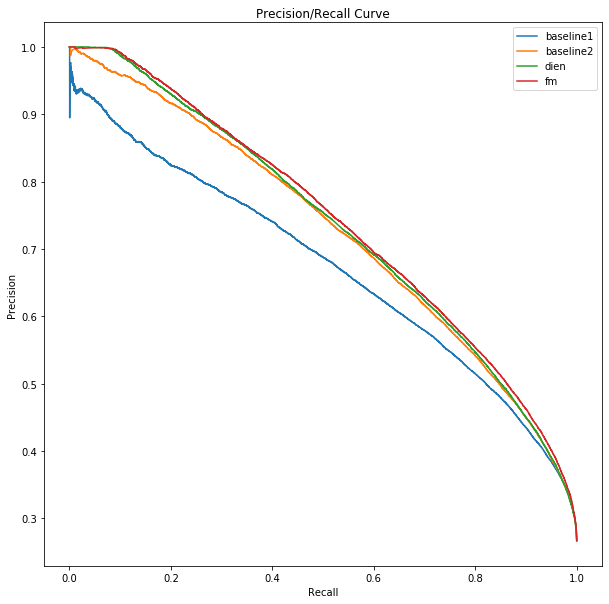

In [181]:
plt.figure("P-R Curve",figsize=(10,10))
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_bl1,precision_bl1,label='baseline1')
plt.plot(recall_bl2,precision_bl2,label='baseline2')
plt.plot(recall_dien,precision_dien,label='dien')
plt.plot(recall,precision,label='fm')
plt.legend()
plt.show()


In [182]:
del df

In [183]:
def get_top_pr(df,i):
    pred_test = df['pred_test']
    cuts = np.arange(int(10), 100, int(10))
    cut_test = np.percentile(pred_test, cuts) 
    df_top1 = df[df['pred_test']>cut_test[len(cut_test)-i]]
    precision = df_top1['test_label'].value_counts()[1]/df_top1.shape[0]
    recall = df_top1['test_label'].value_counts()[1]/df['test_label'].value_counts()[1]
    return precision,recall


In [192]:
df_1 = pd.DataFrame(test_label,columns=['test_label'])
df_1['pred_test'] = test_pred_bl1
p_1,r_1=get_top_pr(df_1,1)
p_1,r_1

(0.7859376191565622, 0.2951486339423793)

In [193]:
df_2 = pd.DataFrame(test_label,columns=['test_label'])
df_2['pred_test'] = test_pred_baseline2
p_2,r_2=get_top_pr(df_2,1)
p_2,r_2

(0.8546480591779151, 0.3209519445558165)

In [194]:
df = pd.DataFrame(test_label,columns=['test_label'])
df['pred_test'] = pred_test
p,r=get_top_pr(df,1)
p,r

(0.864866925951346, 0.3247895068446074)

In [195]:
df_4 = pd.DataFrame(test_label,columns=['test_label'])
df_4['pred_test'] = test_pred_dien
p_4,r_4=get_top_pr(df_4,1)
p_4,r_4

(0.864028063753527, 0.324474483074632)

In [20]:
fm_test_pred = pd.read_csv(new_model_pred_test_path,sep='\t')

In [24]:
fm_test_pred['label'] = test_label

In [25]:
fm_test_pred.head()

,fm_pred_test,label
0,0.105050,0
1,0.047718,0
2,0.002010,0
3,0.442537,0
4,0.230132,0


In [26]:
cuts = np.arange(int(10), 100, int(10))
cut_old = np.percentile(fm_test_pred['fm_pred_test'], cuts) 
cut_old = np.append(np.array([float('-Inf')]), cut_old, axis=0)
cut_old = np.append(cut_old, np.array([float('Inf')]), axis=0)
br_old = fm_test_pred.groupby(pd.cut(fm_test_pred['fm_pred_test'], cut_old))['label'].mean()

df = pd.DataFrame({
                   'cut': fm_test_pred.groupby(pd.cut(fm_test_pred['fm_pred_test'], cut_old))['fm_pred_test'].mean().index.astype(str),
                   'rate' : br_old.values,
                   
                  })

In [30]:
df['rate']

0    0.006406
1    0.023261
2    0.050946
3    0.082672
4    0.132550
5    0.197987
6    0.291718
7    0.415574
8    0.597010
9    0.864867
Name: rate, dtype: float64

# pb

In [30]:
def model_save_as_pb(combine_model,save_model_file,save_pb_file_path,save_pb_file_name):
    
    combine_model.load_weights(save_model_file)
    for node in combine_model.inputs:
        print(node.op.name)

    for node in combine_model.outputs:
        print(node.op.name)

    from util_func.gen_pb import convert_variables_to_constants
    graph = convert_variables_to_constants(K.get_session(), K.get_session().graph_def, output_node_names=["fc_output/Sigmoid"],)
    tf.train.write_graph(graph, save_pb_file_path, save_pb_file_name, as_text=False)   

    a = np.array([0.8]*260).reshape(1,10,26)
    b = np.array([0.8]*255).reshape(1,15,17)
    c = np.array([0.7]*1100).reshape(1,20,55)
    d = np.array([0.7]*194).reshape(1,194)
    f1 = np.array([1]*107).reshape(1,107)
    f2 = np.array([1]*39).reshape(1,39)
    f3 = np.array([1]*22).reshape(1,22)
    f4 = np.array([1]*46).reshape(1,46)

    with tf.Graph().as_default():
        output_graph_def = tf.GraphDef()

        with open(save_pb_file_path+"/"+save_pb_file_name, "rb") as f:
            output_graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(output_graph_def, name="")

        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)

            output = sess.graph.get_tensor_by_name("fc_output/Sigmoid:0")
            input_event_seq = sess.graph.get_tensor_by_name("event_seq_input:0")
            input_loan_seq = sess.graph.get_tensor_by_name("loan_seq_input:0")
            input_repay_seq = sess.graph.get_tensor_by_name("repay_seq_input:0")
            input_baseline = sess.graph.get_tensor_by_name("baseline_top_inputs:0")
            fm_fea = sess.graph.get_tensor_by_name("fm_fea:0")
            fm_fea_accont = sess.graph.get_tensor_by_name("fm_fea_accont:0")
            fm_fea_user_fins = sess.graph.get_tensor_by_name("fm_fea_user_fins:0")
            fm_fea_user_people = sess.graph.get_tensor_by_name("fm_fea_user_people:0")
            
            demo = sess.run(output, feed_dict={input_loan_seq:a,
                                                  input_repay_seq:b,
                                                  input_event_seq:c,
                                                  input_baseline:d,
                                                  fm_fea:f1,
                                                  fm_fea_accont:f2,
                                                  fm_fea_user_fins:f3,
                                                  fm_fea_user_people:f4
                                              })
    if demo == combine_model.predict([a, b, c, d,f1,f2,f3,f4]):
        print(demo,"done!")
    else:
        print("error!")

In [31]:
model_save_as_pb(combine_model,save_model_file,save_pb_file_path,save_pb_file_name)

loan_seq_input
repay_seq_input
event_seq_input
baseline_top_inputs
fm_fea
fm_fea_accont
fm_fea_user_fins
fm_fea_user_people
fc_output/Sigmoid
INFO:tensorflow:Froze 25 variables.
INFO:tensorflow:Converted 25 variables to const ops.
[[0.78487563]] done!


In [29]:
save_model_file

'/home/odin/chengbixiao/git_code/User_loan_demand/user_loan_demand/offline/data/0909/model_file/fm_64_107_3_0909.h5'